# Anime Face Generation using [Generative Adverserial Networks (GANs)](https://en.wikipedia.org/wiki/Generative_adversarial_network)

**Faris Hijazi**

This is a fork of the [Udacity deep learning with Pytorch nanodegree](https://www.udacity.com/course/deep-learning-pytorch--ud188) [DCGAN face generation project](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/project-face-generation).

However some heavy modifictions and **updgrades** have been made, such as extending the GANs and adding support for checkpoints as well as connecting with [Tensorboard](https://www.tensorflow.org/tensorboard)

In this project. The goal is to get a generator network to generate *new* images of faces that look as realistic as possible.

<!--
### Get the Data

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`
-->

## Todo list:

- [x] automate the creation of neural networks given depth parameter
- [x] connect to tensorboard
- [ ] add attention maps
- [ ] use labels to improve training

Some resources:
- https://github.com/soumith/ganhacks
- [batch norm](https://gist.github.com/shagunsodhani/4441216a298df0fe6ab0)
- https://sites.google.com/view/cvpr2018tutorialongans/
- this guys makes GANs using keras and it's so simple! CHECK IT!!! https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/


In [1]:
import json
import os
import pickle as pkl
import time
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import ImageFile
from torchvision import datasets, transforms

import unittests as tests
import utils


ImageFile.LOAD_TRUNCATED_IMAGES = True

%load_ext tensorboard
%matplotlib inline

In [2]:
# Define model hyperparams

# config = {
#     'd_conv_dim': 256,
#     'g_conv_dim': 256,
#     'n_layers': 4,
#     'z_size': 128,
#     'img_size': (96, 96, 3),
#     'batch_size': 64,
# }

# config = {
#     'd_conv_dim': 128,
#     'g_conv_dim': 128,
#     'n_layers': 3,
#     'z_size': 128,
#     'img_size': (32, 32, 3),
#     'batch_size': 64,
# }

config = {
    'd_conv_dim': 64,
    'g_conv_dim': 64,
    'n_layers': 2,
    'z_size': 50,
    'img_size': (32, 32, 3),
    'batch_size': 64,
}

img_size = config['img_size']
d_conv_dim = config['d_conv_dim']
g_conv_dim = config['g_conv_dim']
n_layers = config['n_layers']
z_size = config['z_size']
batch_size = config['batch_size']


In [3]:
# directories should be followed by a "/"
data_dir = "D:/Buza/Projects/datasets/anime-faces/"

data_dir_name = os.path.split(os.path.split(data_dir)[0])[-1]

data_name = '{}-{}'.format(data_dir_name, 'x'.join(map(str, img_size[0:2]))).replace(' ', '_')

assert os.path.isdir(data_dir)

print(f'Data directory: "{data_name}"')

os.makedirs(f'./runs/{data_name}/samples', exist_ok=True)
os.makedirs(f'./runs/{data_name}/checkpoints', exist_ok=True)

Data directory: "anime-faces-32x32"


## Visualize the Data

<!-- The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. -->
Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you.
Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

<!-- #### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in. -->

## Create a DataLoader

#### Exercise: Create a DataLoader anime `train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
def get_dataloader(batch_size, img_size, data_dir=data_dir, num_workers=0):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # convert data to torch.FloatTensor
    transform = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(30),
        transforms.Resize(img_size[0:2]),
#         transforms.Grayscale(3) if img_size[2] else transforms.ToTensor(),
        transforms.ToTensor(),
    ])

    # get the training datasets
    train_data = datasets.ImageFolder(root=data_dir, transform=transform)

    # prepare data loader
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=num_workers)
    
    return train_loader


# Call your function and get a dataloader
train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

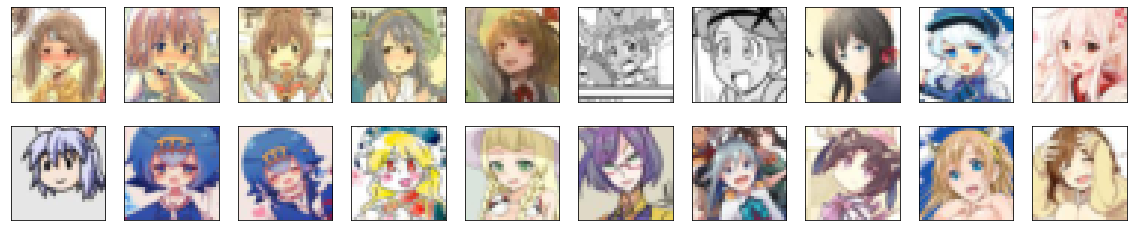

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(train_loader)

for i in range(7):
    dataiter.next()

images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = utils.scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.6392)
Max:  tensor(1.)


In [7]:
from importlib import reload;reload(utils)

<module 'utils' from 'D:\\Buza\\Projects\\ML\\nd101sa\\deep-learning-v2-pytorch\\Anime-GAN\\utils.py'>

# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32, n_layers=4, dropout_prob=0.35, n_classes=1, in_shape=(32,32,3)):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.in_shape = in_shape
        
        self.convs = [None]*self.n_layers
        # starting with last layer
        for i in range(self.n_layers, 0, -1):
            layer_num = self.n_layers-i+1
            batch_norm = True
            in_channels = conv_dim*(2**(layer_num-2))
            out_channels = conv_dim*(2**(layer_num-1))
            
            if i==self.n_layers:
                batch_norm = False # batch_norm for last layer only
                in_channels = in_shape[2]
            
            conv_ = utils.conv(in_channels, out_channels, 4, batch_norm=batch_norm)
            self.convs[layer_num-1] = conv_
            setattr(self, f'conv{layer_num}', conv_)
#             print(f'conv{layer_num}', conv_)
        
        assert len(self.convs)==self.n_layers
        
#         # complete init function
#         # in 32x32x3
#         self.conv1 = utils.conv(3,          conv_dim,   4, stride=2, batch_norm=False)
#         # out 16x16x(conv_dim)
#         self.conv2 = utils.conv(conv_dim,   conv_dim*2, 4, stride=2, batch_norm=True)
#         # out 8x8x(conv_dim*2)
#         self.conv3 = utils.conv(conv_dim*2, conv_dim*4, 4, stride=2, batch_norm=True)
#         # out 4x4x(conv_dim*4)
#         self.conv4 = utils.conv(conv_dim*4, conv_dim*8, 4, stride=2, batch_norm=True)
#         # out 2x2x(conv_dim*8)

#         print('convs', self.convs)
        
        self.conv_out_size = (
            conv_dim*(2**(n_layers-1)),
            in_shape[0]//(2**(n_layers)), 
            in_shape[1]//(2**(n_layers)),
        )
        self.fc = nn.Linear(np.prod(self.conv_out_size), n_classes)
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.dropout = nn.Dropout(dropout_prob)
        self.apply(utils.weights_init_normal)

    def forward(self, x):
        # x: size(batch_size, 32, 32, 3)
        x = x.to(self.get_device())
        
        batch_size = x.size(0)
        
        # starting with last layer
        for i in range(1, self.n_layers+1, 1):
            conv_ = getattr(self, f'conv{i}')
            x = self.leaky_relu(self.dropout(conv_(x)))

        # flatten
        x = x.view(batch_size, np.prod(self.conv_out_size))
        x = self.fc(x)
        return x
    
    def get_device(self):
        dev = next(self.parameters()).get_device()
        dev = 'cpu' if dev == -1 else f'cuda:{dev}'
        return dev

tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [9]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=32, n_layers=4, out_shape=(32, 32, 3), dropout_prob=0.5):
        """Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.z_size = z_size
        self.n_layers = n_layers
        self.out_shape = out_shape
        
        self.conv_in_size = (
            conv_dim*(2**(n_layers-1)),
            out_shape[0]//(2**(n_layers)), 
            out_shape[1]//(2**(n_layers)),
        )
#         print('self.conv_in_size', self.conv_in_size)
        
        self.fc = nn.Linear(z_size, np.prod(self.conv_in_size))
        
        self.deconvs = [None]*self.n_layers
        
        # starting with last layer
        for i in range(1, self.n_layers+1, 1):
            layer_num = self.n_layers-i+1
            batch_norm = True
            in_channels = conv_dim*(2**(i-1))
            out_channels = conv_dim*(2**(i-2))
            
            if i==1:
                batch_norm = False # batch_norm for last layer only
                out_channels = out_shape[2]
            
            deconv_ = utils.deconv(in_channels, out_channels, 4, batch_norm=batch_norm)
            self.deconvs[layer_num-1] = deconv_
            setattr(self, f'deconv{layer_num}', deconv_)
#             print(f'deconv{layer_num}', deconv_)
        
        assert len(self.deconvs)==self.n_layers
        
#         # in 2x2x(conv_dim*8)
#         self.deconv1 = utils.deconv(conv_dim*8, conv_dim*4, 4)
#         # in 4x4x(conv_dim*4)
#         self.deconv2 = utils.deconv(conv_dim*4, conv_dim*2, 4)
#         # out 8x8x(conv_dim*2)        
#         self.deconv3 = utils.deconv(conv_dim*2, conv_dim,   4)
#         # out 16x16x(conv_dim)
#         self.deconv4 = utils.deconv(conv_dim,   3,          4, batch_norm=False)
#         # out 32x32x3
        
#         print('deconvs', self.deconvs)
        
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.apply(utils.weights_init_normal)

    
    def forward(self, x):
        """Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = x.to(self.get_device())
        
        batch_size = x.size(0)
        
        

        x = self.fc(x)
        x = x.view(batch_size, *self.conv_in_size)
        
        # starting with last layer
        for i in range(1, self.n_layers+1, 1):
            deconv_ = getattr(self, f'deconv{i}')
            x = deconv_(x)
            if i!=self.n_layers: # if not last layer
                x = self.leaky_relu(self.dropout(x))

#         x = self.leaky_relu(self.dropout(self.deconv1(x)))
#         x = self.leaky_relu(self.dropout(self.deconv2(x)))
#         x = self.leaky_relu(self.dropout(self.deconv3(x)))
#         x = self.deconv4(x)

        return torch.tanh(x)
    
    def get_device(self):
        dev = next(self.parameters()).get_device()
        dev = 'cpu' if dev == -1 else f'cuda:{dev}'
        return dev
    
    def generate(self, batch_size):
        return self(Generator.gen_z(batch_size, self.z_size))
    
    @staticmethod
    def gen_z(batch_size, z_size):
        return torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size,z_size))).float()

tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [10]:
n_classes = 1
D = Discriminator(d_conv_dim, n_layers=n_layers, in_shape=img_size, n_classes=n_classes)
G = Generator(z_size=z_size,  n_layers=n_layers, out_shape=img_size , conv_dim=g_conv_dim)


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'#remove me
if device == 'cuda':
    print(f"USING {torch.cuda.device_count()} GPU!")

dev0, dev1 = 'cuda', 'cuda'
# if device == 'cuda' and torch.cuda.device_count() > 1:
#     dev0, dev1 = 'cuda:0', 'cuda:1'

# move models to GPU
# D.to(dev0)
# G.to(dev1)

USING 2 GPU!


## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

I tried beta1=0.1 and beta2=0.9 but the discriminator kept overwhelming the generator, we need a good generator here

In [12]:
# params
beta1 = 0.3
beta2 = 0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.SGD(D.parameters(), lr=0.0003, momentum=0.5)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(beta1, beta2))

## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [13]:
# Calculate losses
def real_loss(D_out, labels=None, smooth=False):
    """Calculates how close discriminator outputs are to being real.
       :param, D_out: discriminator logits
       :param labels: 
       :param smooth: 
       :return: real loss"""

#     dev = D_out.get_device()
#     device = dev = 'cpu' if dev == -1 else f'cuda:{dev}'
    criterion = nn.BCEWithLogitsLoss()

    if labels is not None:
        # labels passed
        criterion = nn.CrossEntropyLoss()
    else:
        # labels are 1's
        labels = torch.ones(D_out.size(0))
        D_out = D_out.squeeze()

    if smooth:
        labels -= np.abs(np.random.normal(scale=0.15))

    return criterion(D_out, labels.to(D_out.to(device)))


def fake_loss(D_out, device=device):
    """Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss"""
#     dev = D_out.get_device()
#     device = dev = 'cpu' if dev == -1 else f'cuda:{dev}'

    criterion = nn.BCEWithLogitsLoss()

    labels = torch.zeros(D_out.size(0))

    return criterion(D_out.squeeze(), labels.to(device))

## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

In [14]:
from torch.utils.tensorboard import SummaryWriter, 
import subprocess

log_dir = f'runs/{data_name}'
writer = SummaryWriter(log_dir)

port = 6006
# subprocess.Popen(["tensorboard", f'--logdir="{log_dir}"', f"--port={port}"])
# subprocess.Popen(["run_tensorboard.bat"])

#FIXME: doesn'tensorboard doesn't detect the stuff

print(f'visit:\n http://localhost:{port}')

visit:
 http://localhost:6006


In [15]:
# checking if a checkpoint exists

ckpt = utils.load_ckpt(f'runs/{data_name}.old/checkpoints')
if ckpt is not None:
    print(ckpt.keys())

Checkpoint loaded: runs/anime-faces-32x32.old/checkpoints\checkpoint_8.ckpt
dict_keys(['epoch', 'batch', 'D_state_dict', 'D_optimizer_state_dict', 'D_loss', 'G_state_dict', 'G_optimizer_state_dict', 'G_loss', 'samples', 'fixed_z'])


In [16]:
import session
from utils import dict_update

In [43]:
def train(D,
          G,
          n_epochs,
          print_every=100,
          save_every=100,
          device='cpu',
          path=f'runs/{data_name}',
          ckpt=True):
    """ Trains adversarial networks for some number of epochs
        :param D: (Discriminator) the discriminator network
        :param G: (Generator) the generator network
        :param n_epochs: (int) number of epochs to train for
        :param print_every: (int) when to print and record the models' losses
        :param sess: (dict) old session. dict or path to session dict or None: auto loads '.sess.json' file.
                           To stop this, pass an empty dict
        :param path: (str) path to work directory where checkpoints and logs will be dumped, defaults: "runs/{data_name}/"
        return: D and G losses"""
    import time, json, datetime

    # move models to GPU
    D.to(dev0)
    G.to(dev1)

    global batch_size
    sample_size = 16

    sess = session.Sess(
        defaults={
            'batch_size': batch_size,
            'path': path,

            # keep track of loss and generated, "fake" samples
            'samples': [],
            'D': {
                'state_dict': D.state_dict(),
                'optimizer_state_dict': d_optimizer.state_dict(),
                'loss': 0,
                'losses': [],
            },
            'G': {
                'state_dict': G.state_dict(),
                'optimizer_state_dict': g_optimizer.state_dict(),
                'loss': 0,
                'losses': [],
            },
            'z_fixed': Generator.gen_z(sample_size, z_size).to(dev1),
            'epoch': 0,  # completed epochs
            'batch': 0,  # completed batches
            'alltime_start_time': time.time(),
        })

    ## Load checkpoint
    sess.load(ckpt)

    D.load_state_dict(sess['D']['state_dict'])
    #         d_optimizer.load_state_dict(sess['D']['optimizer_state_dict'])
    G.load_state_dict(sess['G']['state_dict'])
    #         g_optimizer.load_state_dict(sess['G']['optimizer_state_dict'])

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance

    sess['start_time'] = time.time()
    start_epochs = sess['epoch']
    n_epochs += start_epochs

    #     print('sess', sess.keys())

    # epoch training loop
    for epoch in range(start_epochs, n_epochs, 1):
        epoch_start_time = time.time()

        # batch training loop
        for batch_i, (real_images, labels) in enumerate(train_loader):
            real_images = utils.scale(real_images).to(dev0)
            # labels = labels.to(dev0)

            d_optimizer.zero_grad()
            g_optimizer.zero_grad()

            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================
            # 1. Train with REAL images
            d_out_r = D(real_images)

            # Compute the discriminator losses on REAL images (use smoothed labels)
            #!!!! TODO: use labels!!!!
            d_loss_r = real_loss(d_out_r, smooth=False)

            # 2. Train with fake images
            # Generate fake images
            fake_images = G.generate(batch_size)

            # Compute the discriminator losses on FAKE images
            d_out_f = D(fake_images)
            d_loss_f = fake_loss(d_out_f)

            # add up real and fake losses and perform backprop
            d_loss = d_loss_f + d_loss_r

            # retain_graph=True so that we can reuse this info for the generator
            d_loss.backward(retain_graph=True)
            d_optimizer.step()

            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================

            # 1. Train with fake images and flipped labels

            # Generate fake images.  (we already generated those images up there,)
            # Compute the discriminator losses on fake images.  using flipped labels!

            # G loss, is how likely were the fake images believable by D?
            g_loss = real_loss(d_out_f)

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            # Print some loss sess
            if batch_i % sess['print_every'] == 0:
                # append discriminator loss and generator loss
                sess['G']['losses'].append(g_loss.item())
                sess['D']['losses'].append(d_loss.item())

                # print discriminator and generator loss
                print(
                    'Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.
                    format(epoch + 1, n_epochs, d_loss.item(), g_loss.item()))

            if batch_i % sess['save_every'] == 0 or (batch_i == 0 and epoch == 0):
                ## save checkpoint
                #                 try:
                
                dict_update(
                    sess, {
                        'epoch': epoch,
                        'batch': batch_i,
                        'D': {
                            'state_dict': D.state_dict(),
                            'optimizer_state_dict': d_optimizer.state_dict(),
                            'loss': d_loss.item(),
                        },
                        'G': {
                            'state_dict': G.state_dict(),
                            'optimizer_state_dict': g_optimizer.state_dict(),
                            'loss': g_loss.item(),
                        },
                    })

                torch.save(
                    sess,
                    os.path.join(path, f'checkpoints/checkpoint_{epoch}.ckpt'))
                #                 except Exception as e:
                #                     print("ERROR: saving models and training loss:", e)

                # ================================================================== #
                #                        Tensorboard Logging                         #
                # ================================================================== #
                models_losses = {'D': (D, d_loss), 'G': (G, g_loss)}
                for model_name, (model, loss) in models_losses.items():
                    # 1. Log scalar values (scalar summary)
                    for tag, value in ({'loss': loss.item()}).items():
                        writer.add_scalar(model_name + '/' + tag, value, epoch)

                    # 2. Log values and gradients of the parameters (histogram summary)
                    for tag, value in model.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('/'.join([model_name, tag]),
                                             value.data.cpu(), epoch)
                        writer.add_histogram(
                            '/'.join([model_name, tag, 'grad']),
                            value.grad.data.cpu(), epoch)
                pass
                # optimization
                #                 del g_loss
                #                 del d_loss

            # once per epoch
            if batch_i == 0:
                # 3. Log training images (image summary)
                # make fixed fakes
                sample = G.eval().forward(sess['z_fixed'])
                G.train()  # back to training mode

                sess['samples'].append(sample)

                images = np.array(list(map(utils.unscale, sample)),
                                  dtype=np.uint8) * -1
                for tag, value in ({'generated images': images}).items():
                    writer.add_images(tag, value, epoch)

                fig, axes = utils.view_samples(epoch, sample)
                plt.savefig(
                    os.path.join(path, f'samples/samples (epoch {epoch}).png'))
                plt.show()
            pass  #end of batch

        ## AFTER EACH EPOCH ##
        if epoch == 0:  # only the first epoch: print expected time needed
            epoch_duration = time.time() - epoch_start_time
            expected_duration_remaining = epoch_duration * (n_epochs - 1)

            later = datetime.datetime.now() + datetime.timedelta(
                expected_duration_remaining)
            # dd/mm/YY H:M:S
            print(
                f'Estimated time needed:\t{utils.elapsed_time(expected_duration_remaining)}.'
                f'\tCome back at around:\t{later.strftime("%d/%m/%Y %I:%M%p")}'
                f'\nepoch takes {utils.elapsed_time(epoch_duration)}')
        pass

    else:
        print('time taken:',
              utils.elapsed_time(time.time() - sess['start_time']))

        return sess

Checkpoint loaded: runs/anime-faces-32x32\checkpoints\checkpoint_300.ckpt
Session loaded from "runs/anime-faces-32x32\checkpoints\checkpoint_300.ckpt"
Epoch [  301/  600] | d_loss: 0.1852 | g_loss: 5.4543


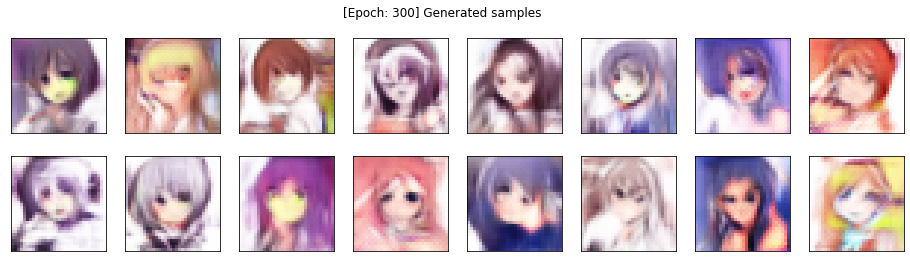

KeyboardInterrupt: 

In [44]:
n_epochs = 300
train_sess = train(
    D,
    G,
    n_epochs=n_epochs,
    print_every=150,
    save_every=50,
    device=device,
    path=f'runs/{data_name}',
    ckpt=20,
)

Load last checkpoint

In [38]:
ckpt = utils.load_ckpt(
    os.path.join(f'runs/{data_name}', 'checkpoints'),
    ckpt=24
)

print('loaded last checkpoint.\nkeys:', list(ckpt.keys()))

Checkpoint loaded: runs/anime-faces-64x64\checkpoints\checkpoint_24.ckpt
loaded last checkpoint.
keys: ['batch_size', 'path', 'samples', 'D', 'G', 'epoch', 'batch', 'alltime_start_time', 'z_fixed', 'print_every', 'save_every', 'start_time']


In [39]:
# load models from checkpoint
D.load_state_dict(ckpt['D']['state_dict'])
G.load_state_dict(ckpt['G']['state_dict'])

<All keys matched successfully>

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

5


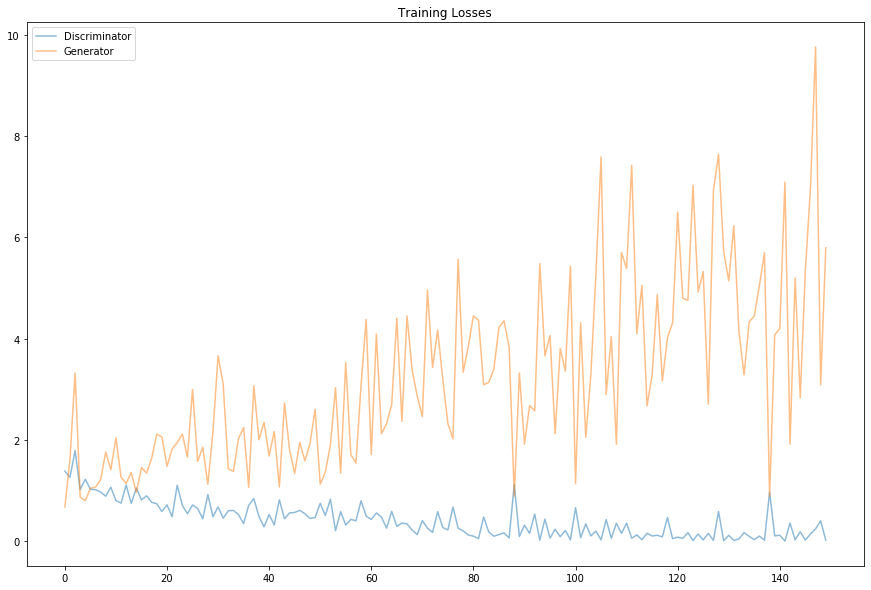

In [123]:
plt.figure(figsize=(15, 10))
plt.plot(ckpt['D']['losses'], label='Discriminator', alpha=0.5)
plt.plot(ckpt['G']['losses'], label='Generator', alpha=0.5)
plt.title("Training Losses")

prints_per_epoch = round(2 * ckpt['print_every'] / (ckpt['batch_size'] + 1))

print(prints_per_epoch)

# plt.xticks([
#     i for i,v in enumerate(ckpt['D']['losses']) if i % prints_per_epoch == 0
# ])

plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

interactive(children=(IntRangeSlider(value=(15, 20), continuous_update=False, description='Epoch range', max=2…

Showing samples from epoch 12 to epoch 21


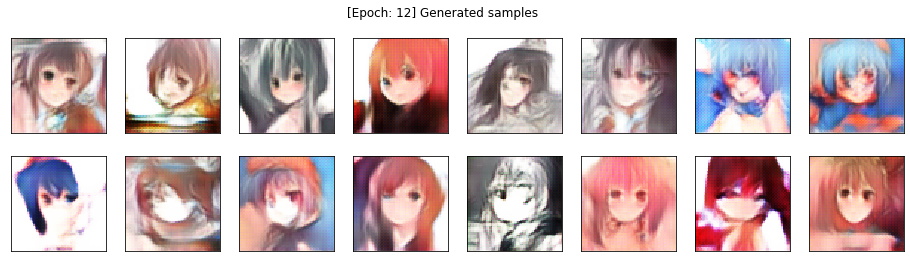

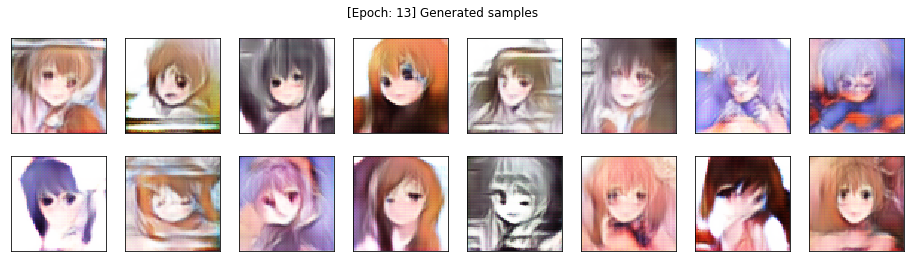

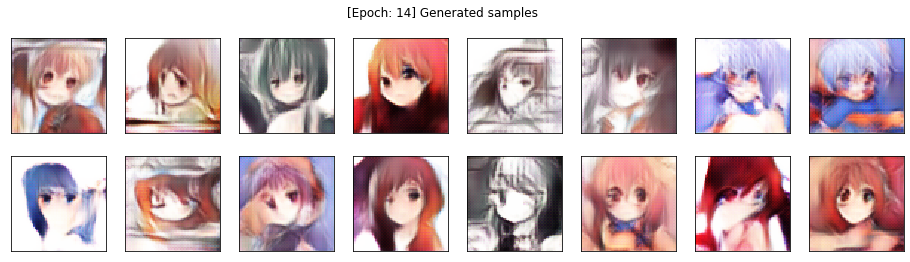

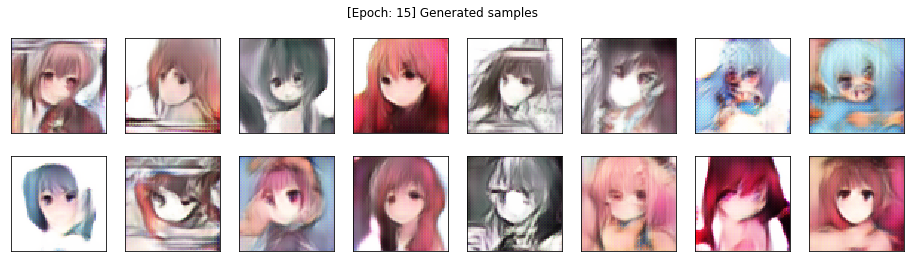

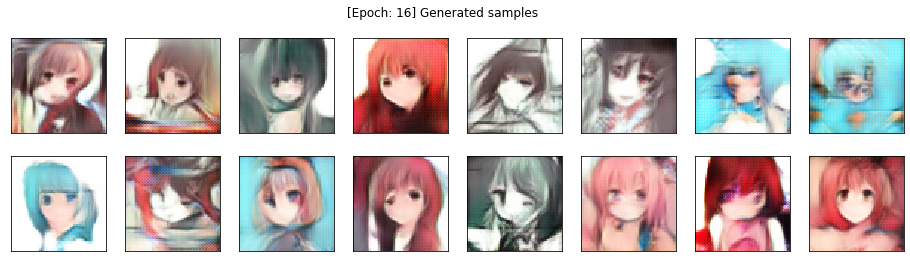

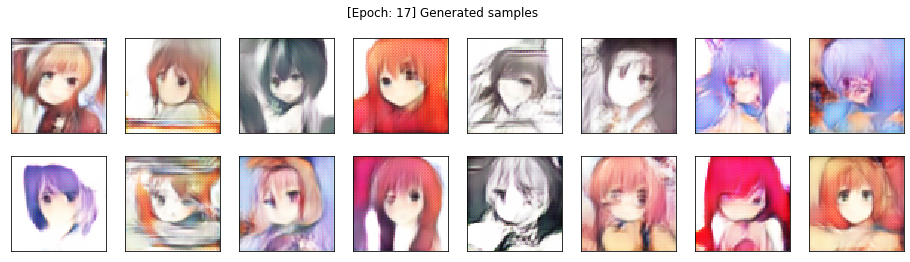

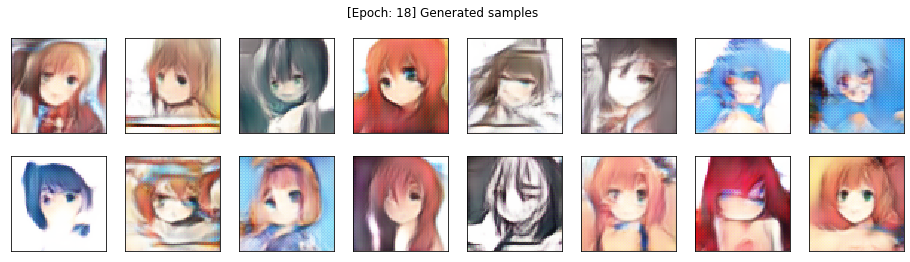

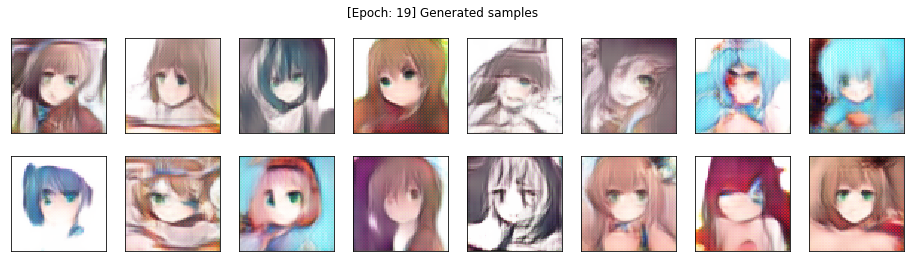

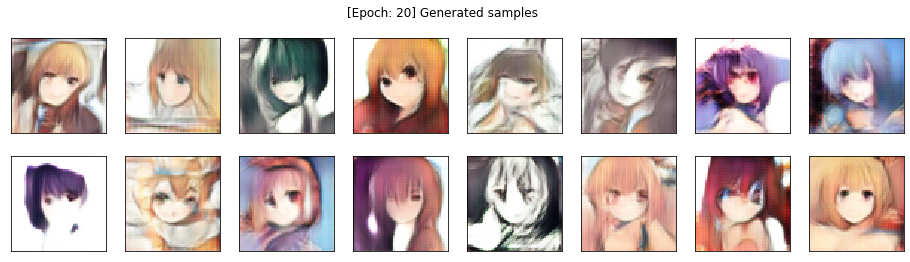

In [169]:
def show_samples_for_epochs(start_end=(-6, -1)):
    start, end = start_end
    start, end = start%len(ckpt['samples']), end%len(ckpt['samples'])
    print(f'Showing samples from epoch {start} to epoch {end}')
    for i in range(start, end, 1):
        f, ax = utils.view_samples(ckpt['samples'][i], i)
    plt.show()

ipywidgets.interact_manual(show_samples_for_epochs, start_end=ipywidgets.IntRangeSlider(
    value=[ckpt['epoch'] - 5, ckpt['epoch']],
    min=0,
    max=ckpt['epoch'],
    step=1,
    description='Epoch range',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
));

# show_samples_for_epochs()


interactive(children=(IntSlider(value=80, continuous_update=False, description='n samples', max=800, step=8), …

time taken to generate 80 samples: 0.005 seconds


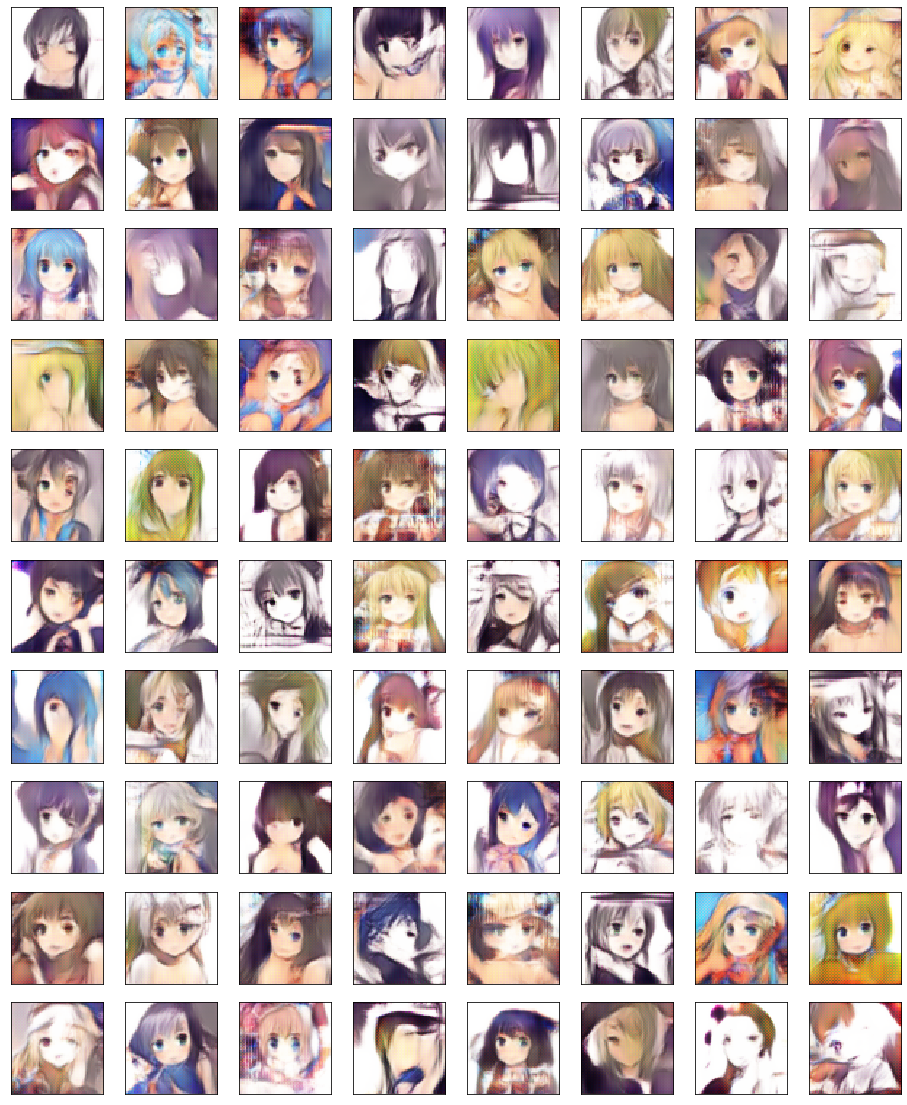

In [176]:
def generate(n=80):
    # generating new random samples (not from the fixed samples)
    G.to(device).eval()
    start_time = time.time()
    sample = G.generate(n)
    print('time taken to generate {} samples: {:.3f} seconds'.format(n, time.time()-start_time))
    fig, axes = utils.view_samples(sample)
    # plt.savefig(os.path.join(path, f'samples/samples (epoch {epoch}).png'))
    plt.show()


ipywidgets.interact_manual(generate, n=ipywidgets.IntSlider(
    value=80,
    min=0,
    max=800,
    step=8,
    description='n samples',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
));

# generate(80)

### Observations on generated samples, and steps to improve this model
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** It did learn to generate things that look like faces, they all have eyes, mouths, and noses, but they still aren't realistic enough.
Now the brute force approach would be to to make a larger model and train for much longer.

But smarter thing to do is to try tweeking the hypterparameters